# Structural and Pfam homogeneity of clusters

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde

In [2]:
file_meta = "~/7_functional_coverage_expansion/foldseekCluster90_1E-5_meta_single_interproscan_1E-3.csv"
df_meta = pd.read_csv(file_meta)

In [54]:
file_stats = "~/7_functional_coverage_expansion/foldseekCluster90_1E-5_stats_single_interproscan_1E-3.csv"
df_stats = pd.read_csv(file_stats)

In [55]:
df_meta.drop([
    'Gene3D_annotation_type',
    'Gene3D_annotation',
    'Gene3D_ratio',
    'SUPERFAMILY_annotation_type',
    'SUPERFAMILY_annotation',
    'SUPERFAMILY_ratio'], axis=1, inplace=True)

In [56]:
df_meta = df_meta.merge(df_stats[['cluster_id', 'cluster_size']], on='cluster_id')

In [ ]:
for cluster_id in df_meta['cluster_id'].unique():

    cluster_size = df_meta[df_meta['cluster_id'] == cluster_id]['cluster_size'].values[0]

    if cluster_size > 1:
        
        pfam_annotated_members = df_meta[(df_meta['cluster_id'] == cluster_id) & (df_meta['Pfam_annotation_type'] == 'Pfam')].shape[0]
        
        if pfam_annotated_members >= 2:
            df_stats.loc[df_stats['cluster_id'] == cluster_id, 'Pfam_consistency'] = 'Pfam 2+'

        print(cluster_id, cluster_size, pfam_annotated_members)
    
    else:
        break

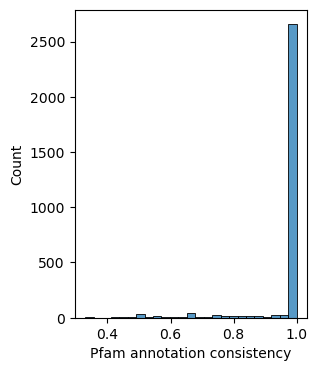

In [59]:
plt.figure(figsize=(3, 4))
sns.histplot(df_stats[df_stats['Pfam_consistency'] == 'Pfam 2+']['Pfam_ratio'], bins=25)
plt.xlabel('Pfam annotation consistency')
plt.savefig(f'./figures/functional_annotation/pfam_consistency_hist.svg', bbox_inches='tight', format='svg')
plt.show()

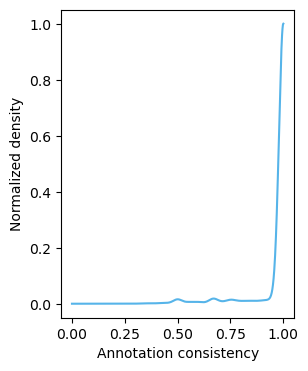

In [11]:
# Split the data based on'annotation_type
data1 = df_stats[df_stats['Pfam_consistency'] == 'Pfam 2+']['Pfam_ratio']

# Compute KDE
kde1 = gaussian_kde(data1)

# Create a range of values for the x-axis
x = np.linspace(0, 1, 1000)

# Compute the densities
density1 = kde1(x)

# Normalize the densities
density1 /= density1.max()

plt.figure(figsize=(3, 4))
plt.plot(x, density1, label='cluster', color='#56B4E9')
plt.xlabel('Annotation consistency')
plt.ylabel('Normalized density')
plt.savefig(f'./figures/functional_annotation/interpro_pfam_annotation_consistency_kde.svg', bbox_inches='tight', format='svg')
plt.show()

In [9]:
file_foldseek = "../foldseek_analysis_all_vs_all.tsv" # FoldSeek results file (over 4.4Gb)
col_names = ["query","target","fident","alnlen","mismatch","gapopen","qstart","qend","qlen","tstart","tend","tlen","evalue","bits","prob","lddt","alntmscore"]
df_foldseek = pd.read_csv(file_foldseek, sep='\t', names=col_names)

In [10]:
df_foldseek_reps = df_foldseek[df_foldseek['query'].isin(df_stats['cluster_representative'])]

In [11]:
# drop rows where the query and target are the same
df_foldseek_reps = df_foldseek_reps[df_foldseek_reps['query'] != df_foldseek_reps['target']]

In [ ]:
for index, row in df_stats.iterrows():

    cluster_id = row['cluster_id']
    cluster_size = row['cluster_size']

    if cluster_size == 1:
        break

    cluster_rep = row['cluster_representative']
    cluster_members = list(df_meta[df_meta['cluster_representative'] == cluster_rep]['cluster_member'])

    df_foldseek_sub = df_foldseek_reps[(df_foldseek_reps['query'] == cluster_rep) & (df_foldseek_reps['target'].isin(cluster_members))]
    foldseek_hits = df_foldseek_sub.shape[0]

    df_stats.loc[df_stats['cluster_representative'] == cluster_rep, 'foldseek_hits'] = foldseek_hits
    
    if foldseek_hits >= 1:

        mean_lddt = round(df_foldseek_sub['lddt'].mean(), 4)
        df_stats.loc[df_stats['cluster_representative'] == cluster_rep, 'mean_lddt'] = mean_lddt
        median_lddt = round(df_foldseek_sub['lddt'].median(), 4)
        df_stats.loc[df_stats['cluster_representative'] == cluster_rep, 'median_lddt'] = median_lddt

        mean_ptm = round(df_foldseek_sub['alntmscore'].mean(), 4)
        df_stats.loc[df_stats['cluster_representative'] == cluster_rep, 'mean_ptm'] = mean_ptm
        median_ptm = round(df_foldseek_sub['alntmscore'].median(), 4)
        df_stats.loc[df_stats['cluster_representative'] == cluster_rep, 'median_ptm'] = median_ptm

        print(cluster_id, foldseek_hits, mean_lddt, median_lddt, mean_ptm, median_ptm, sep='\t')

In [13]:
df_stats

,cluster_id,cluster_size,ictv_lca,ictv_lca_rank,protlen_mean,plddt_mean,ptm_mean,cluster_representative,structure_representative,structure_representative_plddt,...,Gene3D_annotation,Gene3D_ratio,SUPERFAMILY_annotation_type,SUPERFAMILY_annotation,SUPERFAMILY_ratio,foldseek_hits,mean_lddt,median_lddt,mean_ptm,median_ptm
0,1,818,Orthornavirae,Kingdom,466.69,95.29,0.93,CF-AKH10573.1.1.6_7109_relaxed,CF-BAA24003.1.11_10589_relaxed,96.8,...,Reverse transcriptase/Diguanylate cyclase domain,1.00,cluster,DNA/RNA polymerases,1.0,817.0,0.4696,0.4493,0.6405,0.6234
1,2,511,Picornaviridae,Family,173.56,95.65,0.91,EF-AET72467.1.10_10785_relaxed,CF-AKA64451.1.10_10622_relaxed,97.0,...,"Peptidase S1, PA clan, chymotrypsin-like fold",1.00,cluster,Trypsin-like serine proteases,1.0,510.0,0.8590,0.8392,0.9662,0.9686
2,3,509,Viruses,Superkingdom,236.39,81.46,0.73,CF-AFP96991.1.2_10938_relaxed,CF-BAS29593.1.4_10461_relaxed,89.4,...,Viral coat protein subunit,0.87,cluster,Positive stranded ssRNA viruses,1.0,503.0,0.5574,0.6970,0.5685,0.7064
3,4,498,Enterovirus,Genus,68.28,63.25,0.24,CF-ACK37378.1.1.1_10649_relaxed,CF-ACK37378.1.1.1_10649_relaxed,72.1,...,Picornavirus coat protein VP4 superfamily,1.00,cluster,Positive stranded ssRNA viruses,1.0,495.0,0.8578,0.8688,0.5639,0.5483
4,5,497,Enterovirus,Genus,97.98,68.69,0.44,CF-ACJ66736.1.6_10625_relaxed,CF-ACJ66736.1.6_10625_relaxed,84.9,...,NaN,NaN,NaN,NaN,NaN,496.0,0.7544,0.6971,0.6270,0.5268
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19062,19063,1,Ichnoviriform fugitivi,Species,128.00,94.00,0.52,CF-BAF45662.1_12759_relaxed,CF-BAF45662.1_12759_relaxed,94.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19063,19064,1,Ichnoviriform fugitivi,Species,116.00,53.30,0.23,CF-BAF45663.1_12759_relaxed,CF-BAF45663.1_12759_relaxed,53.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19064,19065,1,Ichnoviriform fugitivi,Species,159.00,79.70,0.41,CF-BAF45664.1_12759_relaxed,CF-BAF45664.1_12759_relaxed,79.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19065,19066,1,Ichnoviriform fugitivi,Species,139.00,41.30,0.23,CF-BAF45668.1_12759_relaxed,CF-BAF45668.1_12759_relaxed,41.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
df_stats.to_csv("./foldseekCluster90_1E-5_stats_single_interproscan_1E-3_mean_lddt_tm.csv", index=False)

In [42]:
file_stats = "/foldseekCluster90_1E-5_stats_single_interproscan_1E-3_mean_lddt_tm.csv"
df_stats = pd.read_csv(file_stats)

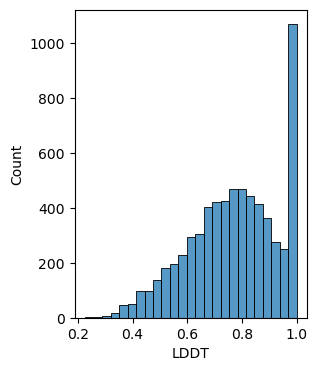

In [51]:
plt.figure(figsize=(3, 4))
sns.histplot(df_stats[df_stats['mean_lddt'].notna()]['mean_lddt'], bins=25)
plt.xlabel('LDDT')
plt.savefig(f'./figures/functional_annotation/lddt_hist.svg', bbox_inches='tight', format='svg')
plt.show()

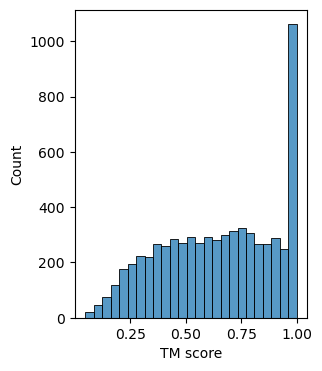

In [52]:
plt.figure(figsize=(3, 4))
sns.histplot(df_stats[df_stats['mean_ptm'].notna()]['mean_ptm'], bins=25)
plt.xlabel('TM score')
plt.savefig(f'./figures/functional_annotation/tm_score_hist.svg', bbox_inches='tight', format='svg')
plt.show()

In [25]:
df_stats[df_stats['mean_lddt'].notna()]['mean_lddt'].median()

0.7806

In [26]:
df_stats[df_stats['mean_ptm'].notna()]['mean_ptm'].median()

0.6637